# Logistic Regression with Python

Dataset: [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic).

We'll be trying to predict a classification- survival or deceased.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning.

## Import Libraries
Let's import some libraries to get started!

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [65]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

In [66]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [68]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


# Missing data

In [69]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Visualization of Missing data points

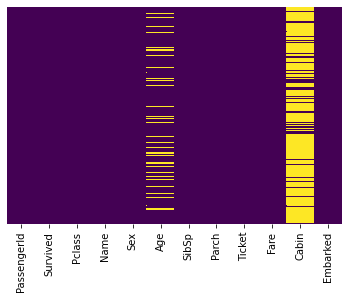

In [70]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis');

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

### check Survived or not column

In [71]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

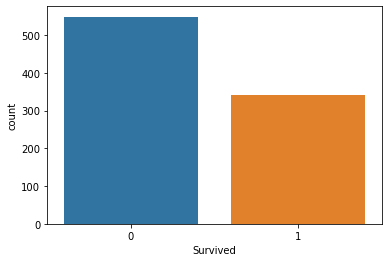

In [72]:
sns.countplot(data=train, x='Survived');

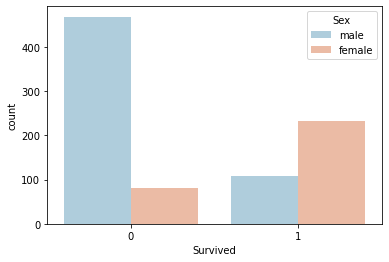

In [73]:
sns.countplot(data=train, x='Survived', hue='Sex', palette='RdBu_r');

We can see a lot of Female survived more than Male.

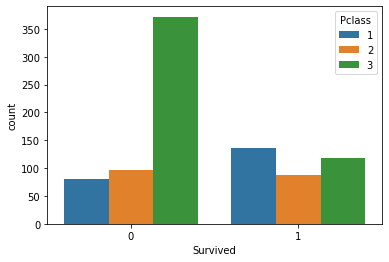

In [74]:
sns.countplot(data=train, x='Survived', hue='Pclass', );

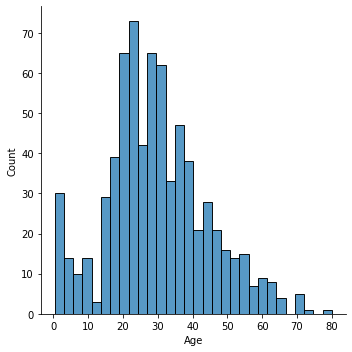

In [75]:
sns.displot(train['Age'].dropna(), bins=30);

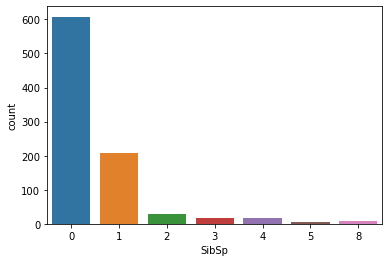

In [76]:
sns.countplot(data=train, x='SibSp');

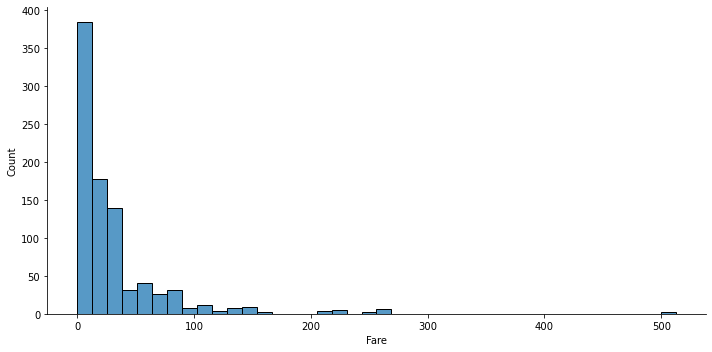

In [77]:
sns.displot(train['Fare'], bins=40, height=5, aspect=2);

-------

# Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


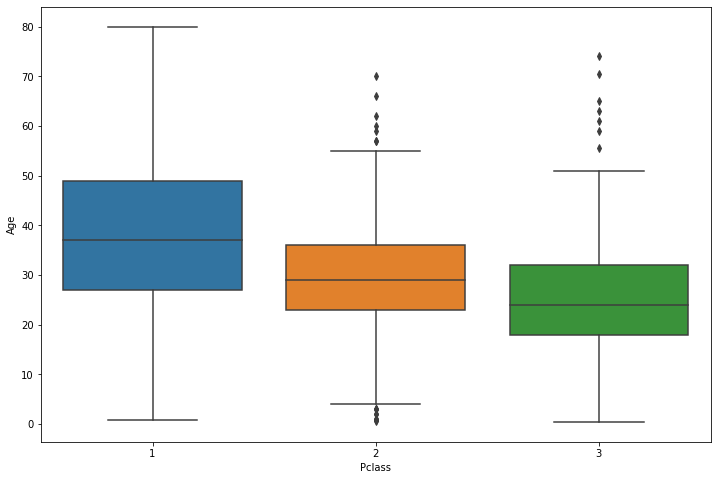

In [78]:
plt.figure(figsize=(12,8))
sns.boxplot(data=train, x='Pclass', y='Age');

In [79]:
# calculate the average age per class
Age_by_class_df = pd.DataFrame(train.groupby('Pclass').mean()['Age'])
Age_by_class_df.head()

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


In [80]:
Age_by_class_df['Round_Age'] = np.array([38, 29, 25])

In [81]:
Age_by_class_df.head()

,Age,Round_Age
Pclass,,
1,38.233441,38
2,29.877630,29
3,25.140620,25


In [82]:
# test out
Age_by_class_df['Round_Age'].loc[1]

38

In [83]:
def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        return Age_by_class_df['Round_Age'].loc[pclass]
    return age

In [84]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis=1)

In [85]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Check heatmap again after filling with Average Age for missing ones

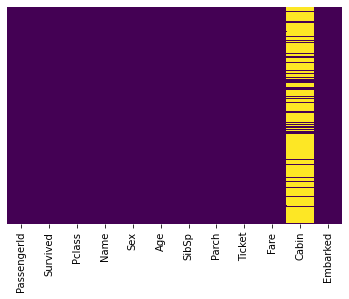

In [86]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis');

-------

#### Drop the cabin column

In [87]:
train = train.drop('Cabin', axis=1)

In [88]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


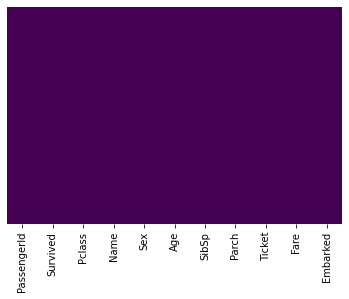

In [89]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [90]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

#### drop Embarked 2 missing rows

In [91]:
train = train.dropna()

In [92]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

----------

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [97]:
# Sex column
sex = pd.get_dummies(train['Sex'], drop_first=True)

sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [98]:
embark  = pd.get_dummies(train['Embarked'], drop_first=True)

embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [99]:
# combine those 3 dataframes

train = pd.concat([train, sex, embark], axis=1)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


### we will drop columns which we will not use

In [100]:
train = train.drop(['Name', 'Ticket', 'Sex', 'Embarked'], axis=1)

In [101]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [103]:
# drop Passenger ID which is not useful for our model
train = train.drop('PassengerId', axis=1)

train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


---------

# Building a Logistic Regression model

In [104]:
# separate features and labels
X = train.drop('Survived', axis=1)
y = train['Survived']

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [107]:
from sklearn.linear_model import LogisticRegression

In [112]:
log_r = LogisticRegression(max_iter=1000)

In [113]:
log_r.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [127]:
predictions = log_r.predict(X_test)

# Evaluation

In [128]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

In [129]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       163
           1       0.85      0.70      0.77       104

    accuracy                           0.84       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.84      0.84      0.83       267



In [130]:
confusion_matrix(y_test, predictions)

array([[150,  13],
       [ 31,  73]], dtype=int64)

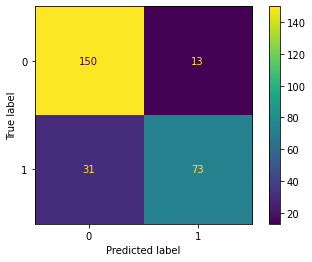

In [136]:
plot_confusion_matrix(log_r, X_test, y_test);